In [1]:
import os
import sys
sys.path.append(os.path.abspath('/home/not-naive-bayes-MIL'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gudhi.point_cloud.knn import KNearestNeighbors
from gudhi.point_cloud.dtm import DistanceToMeasure
from gudhi.clustering.tomato import Tomato

from sklearn.preprocessing import MinMaxScaler

from dataset import correct_repeat_values
from utils import minimize_graph_connections

import json

sns.set_style('whitegrid')
%matplotlib inline

### Load and preprocess data

In [2]:
absolute_path = '/home/data'
data = pd.read_parquet(absolute_path+'/FlowCAP-AML_Panel6.parquet')
with open(absolute_path+('/FlowCAP-AML_status.json')) as f:
    p_states = json.load(f)
p_ids = np.array(list(p_states), dtype=int)
p_states_vals = np.array(list(p_states.values()))

In [4]:
data.columns

Index(['FS Lin', 'SS Log', 'HLA-DR-FITC', 'CD117-PE', 'CD45-ECD', 'CD34-PC5',
       'CD38-PC7', 'p_id'],
      dtype='object')

In [ ]:
p_id = np.random.choice(p_ids[p_states_vals=='aml'], size=1)[0]
print("p_id :", p_id)
tmp = data[data.p_id==p_id].drop(columns=['p_id'])
X = tmp.to_numpy()
print(f"Before saturation correction (size={len(X)}) :", X.mean(axis=0))
# tmp.drop_duplicates(inplace=True)
X = tmp.to_numpy()
d = X.shape[1]
for j in range(d):
    X[:,j] = correct_repeat_values(X[:,j])
print(f"After saturation correction (size={len(X)}) :", X.mean(axis=0))

p_id : 211
Before saturation correction (size=30000) : [610.5655  446.7232  298.55823 312.27628 525.4147  187.6509  493.62573]
After saturation correction (size=30000) : [610.5655  446.7232  298.55823 312.27628 525.4147  187.6509  493.62573]


In [15]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

### Compute kNN graph

In [16]:
k_max = 50

knn_estimator = KNearestNeighbors(
    k=k_max,
    metric='euclidean',
    implementation='ckdtree',
    n_jobs=2
)
neighbors = knn_estimator.fit_transform(X)

### Compute DTM weights

In [17]:
n, d = X.shape
k_dtm = 50 #int(n ** (4/(d+4))) + 1
print("k_dtm :", k_dtm)

dtm_estimator = DistanceToMeasure(
    k=k_dtm,
    q=2,
    d=X.shape[1],
    metric='neighbors'
)
weights = np.log(dtm_estimator.fit_transform(neighbors[:,:k_dtm]))

k_dtm : 50


### Optimize kNN graph

In [ ]:
ngbs_opt = minimize_graph_connections(neighbors, weights)

Time to compute optimized graph : 3.9164090156555176


### Clustering

In [19]:
tm = Tomato(
    graph_type='manual',
    density_type='manual',
    n_clusters = None
).fit(ngbs_opt, weights=weights)
persistances = np.sort(tm.diagram_[:,0] - tm.diagram_[:,1])[::-1]
arg_tau = np.argmax(persistances[:-1] - persistances[1:])
arg_tau = 8 if arg_tau != 8 else arg_tau
tau = (persistances[arg_tau] + persistances[arg_tau + 1]) / 2
tm.merge_threshold_ = tau


In [20]:
cluster_ids, counts = np.unique_counts(tm.labels_)
print("Cluster counts :", counts)
event_to_cluster_count = pd.Series(tm.labels_).map(lambda k: counts[k]).to_numpy()

Cluster counts : [15248   591  1703  8626   325  2042   835   624     3     3]


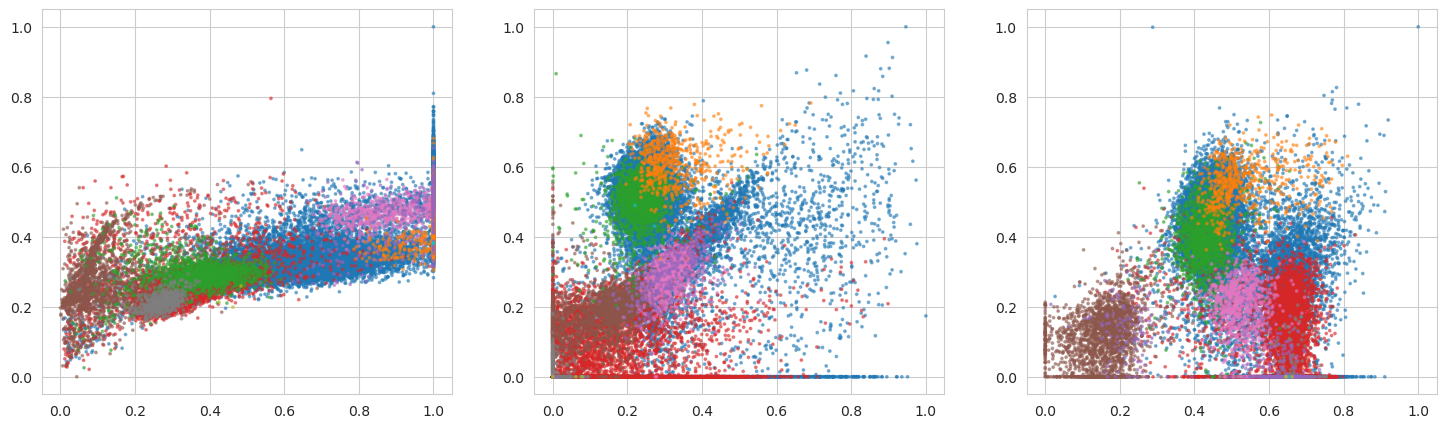

In [21]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

inds = np.argsort(event_to_cluster_count)[::-1]
for j in range(3):
    ax[j].scatter(X[inds,2*j], X[inds,2*j+1], s=3, c=tm.labels_[inds], cmap='tab10', alpha=0.5)
    

In [31]:
data['tomato_cluster'] = -1
data.loc[data.p_id==p_id, 'tomato_cluster'] = tm.labels_

In [35]:
data.iloc[data.p_id==p_id,:7] = X

In [37]:
data[data.p_id==p_id]

,FS Lin,SS Log,HLA-DR-FITC,CD117-PE,CD45-ECD,CD34-PC5,CD38-PC7,p_id,tomto_cluster,tomato_cluster
6083904,548.0,397.0,417.0,342.0,453.0,465.0,521.0,211,-1,0
6083905,473.0,421.0,231.0,348.0,469.0,205.0,563.0,211,-1,3
6083906,1023.0,640.0,497.0,379.0,632.0,214.0,378.0,211,-1,3
6083907,423.0,438.0,344.0,298.0,458.0,515.0,465.0,211,-1,2
6083908,505.0,455.0,339.0,294.0,410.0,153.0,533.0,211,-1,5
...,...,...,...,...,...,...,...,...,...,...
6113899,474.0,392.0,149.0,233.0,443.0,59.0,577.0,211,-1,6
6113900,682.0,457.0,207.0,274.0,542.0,61.0,645.0,211,-1,0
6113901,509.0,408.0,354.0,367.0,473.0,496.0,561.0,211,-1,0
6113902,437.0,405.0,241.0,249.0,694.0,0.0,495.0,211,-1,0
